## **1. Import libraries**

In [ ]:
import os
import torch
from datasets import load_dataset
from unsloth import FastVisionModel

from unsloth import is_bf16_supported
from transformers import TextStreamer
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

## **2. Load model**

In [ ]:
model_name = "unsloth/Qwen2-VL-2B-Instruct"
model, tokenizer = FastVisionModel.from_pretrained(
    model_name,
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

In [ ]:
def prepare_chat_inputs(image, instruction, tokenizer,
                        device="cuda", add_generation_prompt=True):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": instruction}
            ]
        }
    ]


    input_text = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=add_generation_prompt
    )

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to(device)

    return inputs


def run_inference(model, inputs, tokenizer,
                  max_new_tokens=128, temperature=1.5, min_p=0.1):
    FastVisionModel.for_inference(model)

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)

    output_text = model.generate(
        **inputs,
        streamer=text_streamer,
        max_new_tokens=max_new_tokens,
        use_cache=True,
        temperature=temperature,
        min_p=min_p
    )

    return output_text


## **3. Zero-shot Prompting**

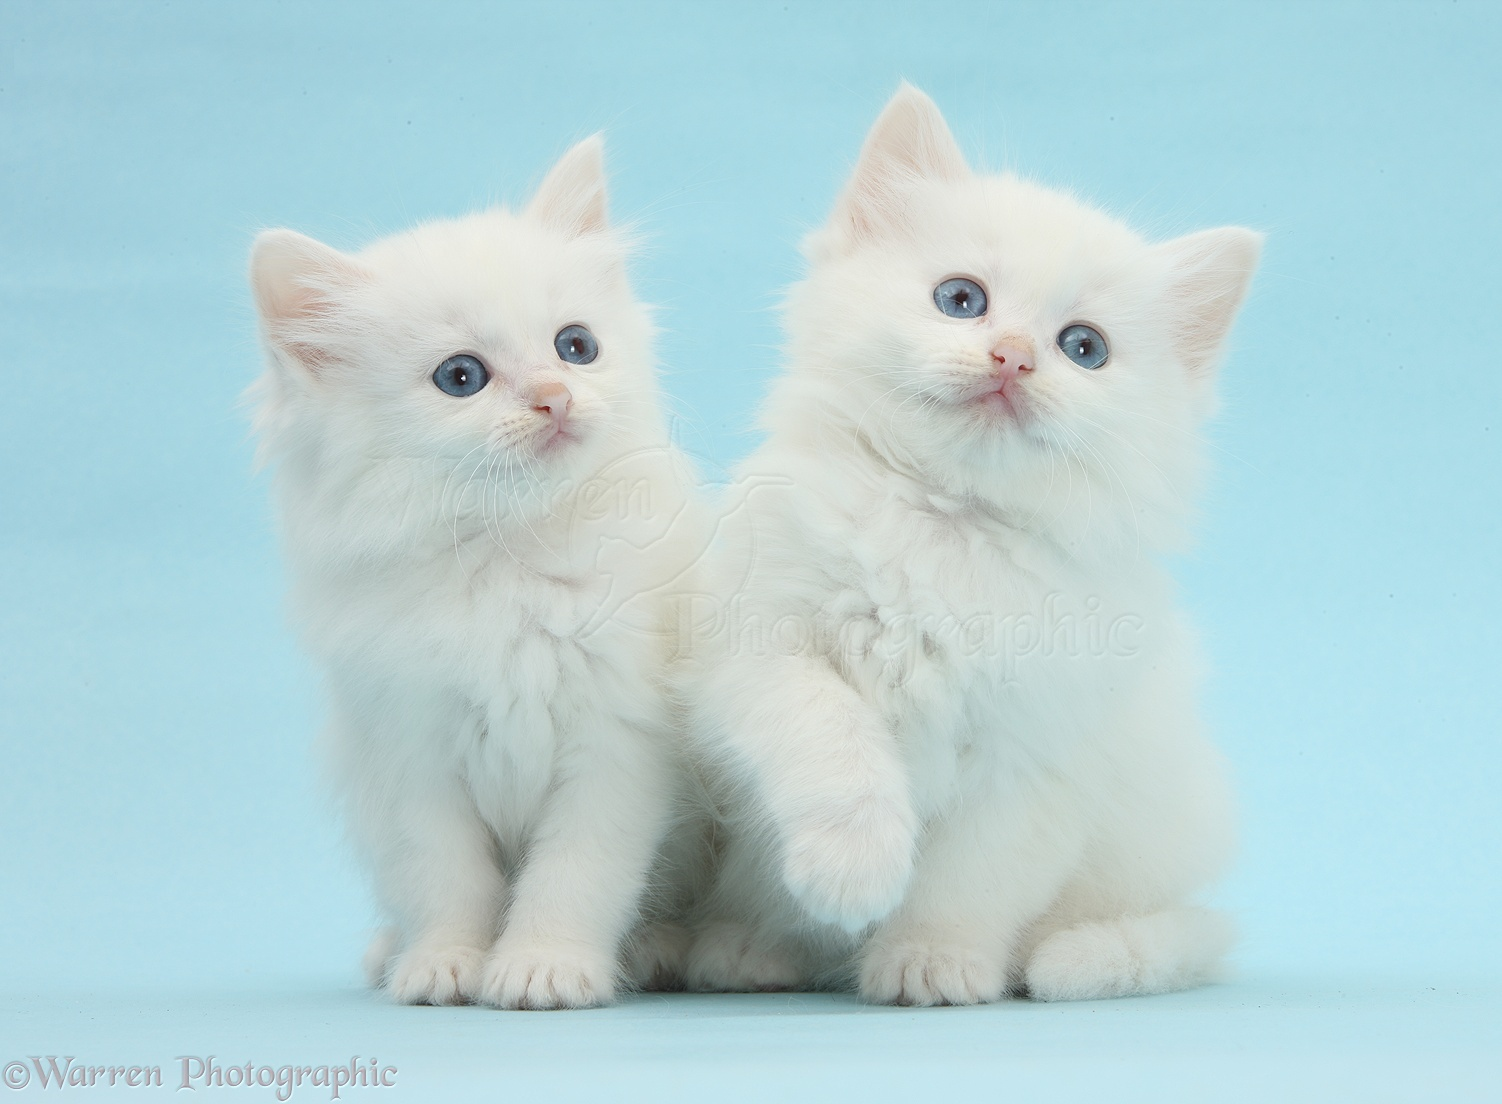

In [ ]:
test_image_path = "cat.jpg"
image = Image.open(test_image_path).convert("RGB")
image

In [ ]:
instruction = "Detect the watermark in this image with bounding box with the format of YOLO"

inputs = prepare_chat_inputs(
    image=image,
    instruction=instruction,
    tokenizer=tokenizer,
    device=device
)

output_text = run_inference(
    model=model,
    inputs=inputs,
    tokenizer=tokenizer,
    max_new_tokens=128,
    temperature=1.5,
    min_p=0.1
)

<|object_ref_start|>the watermark in this image with bounding box<|object_ref_end|><|box_start|>(0,947),(272,997)<|box_end|><|im_end|>


## **4. Few-shot Prompting**

In [ ]:
test_image_path = "cat.jpg"
image = Image.open(test_image_path).convert("RGB")
instruction = """
Answer the question based on the image in the following format: Answer: <answer>

Examples:
- Input: Question: How many cats are in the image?
- Output: Answer: 2

- Input: Question: What is the color of the cat?
- Output: Answer: White

Here is the input:
Question: What is the color of the background?
"""

inputs = prepare_chat_inputs(
    image=image,
    instruction=instruction,
    tokenizer=tokenizer,
    device=device
)

output_text = run_inference(
    model=model,
    inputs=inputs,
    tokenizer=tokenizer,
    max_new_tokens=128,
    temperature=1.5,
    min_p=0.1
)

Answer: Blue<|im_end|>


## **5. CoT Prompting**

In [ ]:
test_image_path = "cat.jpg"
image = Image.open(test_image_path).convert("RGB")
instruction = """
Please think step by step and answer the following question based on the image: Which cat is taller?
"""

inputs = prepare_chat_inputs(
    image=image,
    instruction=instruction,
    tokenizer=tokenizer,
    device=device
)

output_text = run_inference(
    model=model,
    inputs=inputs,
    tokenizer=tokenizer,
    max_new_tokens=128,
    temperature=2.0,
    min_p=0.1
)